# Transformer basic architecture
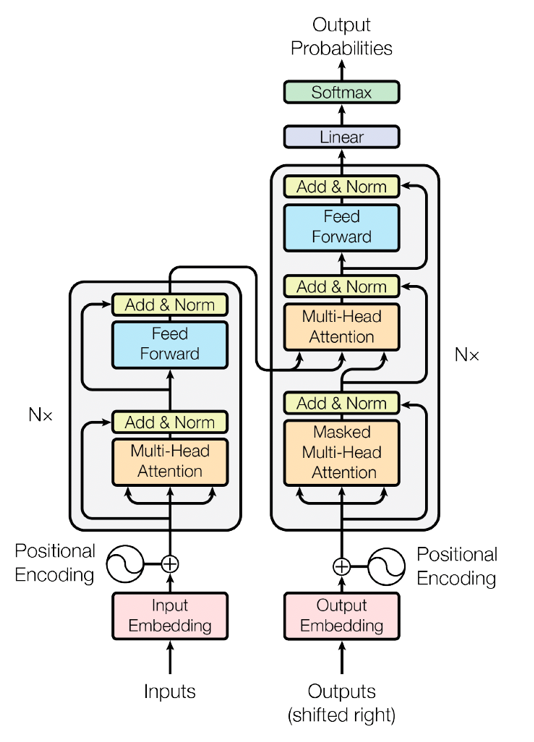

# 1) Main Components:
## Token Embedding & Positional Encoding:
### <span style="color:orange">Embedding:</span>
- The sentence is divided into tokens and then produce the Embedding vector of the token.
- Here, the embedding vector is initialized with random values; as we don't aim to apply a specific application, we just implement the architecture of transformer from scratch.
- There are many ways of vectorization in NLP and Computer vision, but this is not our focus here in this notebook.

### <span style="color:orange">Positional Emcoding (Sinusodial):</span>
$$
PE_{pos,2i} = \sin\!\left(\frac{pos}{10000^{2i/d_{\mathrm{model}}}}\right)
$$

$$
PE_{pos,2i+1} = \cos\!\left(\frac{pos}{10000^{2i/d_{\mathrm{model}}}}\right)
$$

In [1]:
import numpy as np

def positional_encoding(max_len, d_model):
    pe = np.zeros((max_len, d_model))
    positions = np.arange(max_len)[:, None]  # (max_len, 1)
    dims = np.arange(d_model)[None, :]  # (1, d_model)
    angle_rates = positions / np.power(10000, (2*(dims//2)) / d_model)
    pe[:, 0::2] = np.sin(angle_rates[:, 0::2])  # even indicies
    pe[:, 1::2] = np.cos(angle_rates[:, 1::2])  # odd indices
    return pe  # shape: (max_len, d_model)

- We firstly need to get tokens from the input text, then convert them into embedding vectors, there are many approached to do that, but here our focus is on the components of the transformer architecture, so these vectors are set to random assumptions.
- We then need to sum up the embedding vector to the positional encoding vector to get the positon aware vectors, below in `embed` function.

In [2]:
# def embed(tokens):
# """
# tokens: atrray of shape (batch_size, seq_len), dtype=int
# rns: flaor array of shape (batch_size, seq_len, d_model)    retu
#         """
# , seq_length = tokens.shape
# f"Batch size = {batch_size}, and sequence length = {seq_length}")
# tokens]
# print(f"Embeddings of the input tokens: {x}")
#     x += pe[:seq_length]  # add positional encodings
# f"final vectors including positions awarness: {x}")    print(
#     return x        x = embedding[    print(    batch_size

### Scaled Dot Product Attention:
Given queries $Q$, keys $K$, values $V$ (all in $\mathbb{R}^{b\times h\times \ell\times d_k}$), and optional mask $M$:

$$
\mathrm{Attention}(Q, K, V)
\;=\;
\mathrm{softmax}\!\Bigl(\tfrac{QK^T}{\sqrt{d_k}} + M\Bigr)\,V.
$$

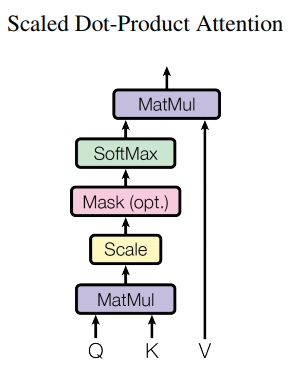

### <span style="color:Orange">Softmax:
$$
\mathrm{softmax}(z)_i \;=\; \frac{e^{z_i}}{\sum_j e^{z_j}}
\;=\; \frac{e^{z_i - C}}{\sum_j e^{z_j - C}}.
$$

In [3]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q, K, V are 3 copies of the final embedding with positional encoding vectors,
    they are of shape (..., seq_len, d_k)

    mask is needed in the decoder, according to the basic architecture,
    their shape is (..., seq_len) with -inf where masked,
    they then converted to 0 after passing into softmax layer

    returns: (output, attention_weights)  # output vector for each head (in the cell next to this cell)
    """
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.swapaxes(-1, -2)) / np.sqrt(d_k)
    if mask is not None:
        # add mask vector into scores/weights vector;
        # where future/pad positions get -inf before softmax in decoder
        # these -inf positions will be 0 after applying softmax
        # so its role is neglected
        scores +=  mask
    attention = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    attention /= np.sum(attention, axis=-1, keepdims=True)  # softmax
    out = np.matmul(attention, V)  # shape: (..., seq_len, d_k)
    return out, attention

### Multi-Head Attention:

Single attention for each token with the others one (each token attention across all other tokens is one head), thus for all tokens, there will be multiple heads. They are working in parallel.

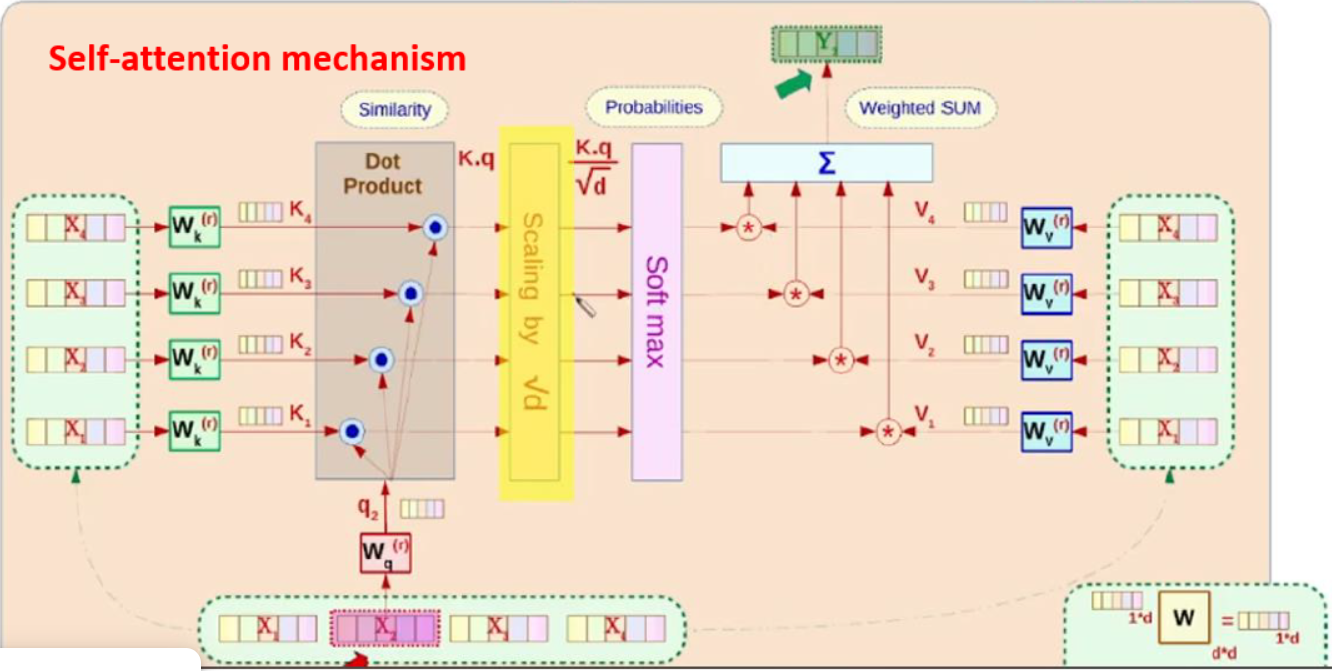

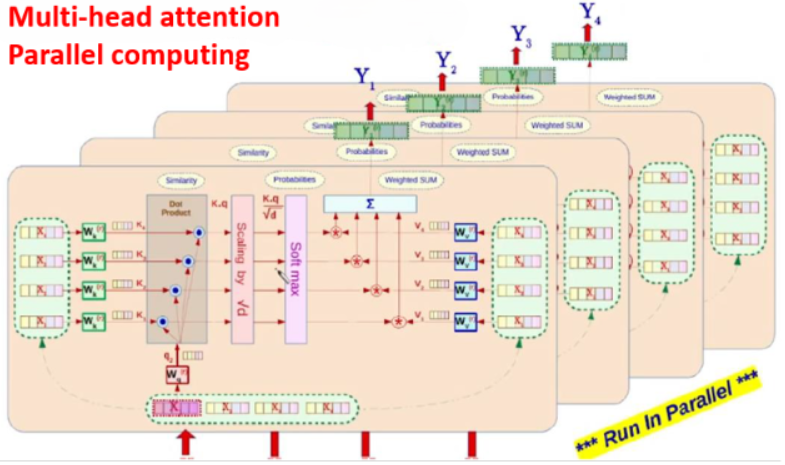

We learn projection matrices

$$
W_Q,\,W_K,\,W_V \;\in\;\mathbb{R}^{d_{\mathrm{model}}\times (h\cdot d_k)},
\quad
W_O \;\in\;\mathbb{R}^{(h\cdot d_k)\times d_{\mathrm{model}}}.
$$

Split the projected \(Q,\,K,\,V\) into \(h\) heads, apply attention per head, then concatenate and project.


In [4]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.h = num_heads
        self.d_k = d_model // num_heads
        # initialize weight matrices with random weights
        self.W_Q = np.random.randn(d_model, d_model) * 0.01
        self.W_K = np.random.randn(d_model, d_model) * 0.01
        self.W_V = np.random.randn(d_model, d_model) * 0.01
        self.W_O = np.random.randn(d_model, d_model) * 0.01

    def split_heads(self, x):
        # x shape: (batch, seq_len, d_model) -> (batch, h, seq_len, d_k)
        b, seq, _ = x.shape
        x = x.reshape(b, seq, self.h, self.d_k)
        return x.transpose(0, 2, 1, 3)

    def combine_heads(self, x):
        # x shape: (batch, h, seq_len, d_k) -> (batch, seq_len, d_model)
        b, h, seq, dk = x.shape
        x = x.transpose(0, 2, 1, 3).reshape(b, seq, h*dk)
        return x

    def __call__(self, x_q, x_k, x_v, mask=None):
        # 1) linear projections
        # Q = x_q . w_Q
        Q = x_q @ self.W_Q  # (b, seq_q, d_model)
        # K = x_k . w_K
        K = x_k @ self.W_K
        # V = x_v * w_V
        V = x_v @ self.W_V

        # 2) split into heads
        Qh = self.split_heads(Q)
        Kh = self.split_heads(K)
        Vh = self.split_heads(V)

        # 3) Scaled dot-product attention
        # if mask is not None:
        #     # expand mask to (b, h, seq_q, seq_k) to match attention vectors shape
        #     mask = mask[:, None, :, :]

        out_heads = []
        for i in range(self.h):
            out_i, _ = scaled_dot_product_attention(Qh[:, i], Kh[:, i], Vh[:, i], mask)
            out_heads.append(out_i)
            # print (f"Head {i}:\n{out_heads[i]}")

        concat = np.stack(out_heads, axis=1)  # (b, h, seq_q, d_k)
        # print(f"Concatenated heads attention vectors: {concat}")

        combined = self.combine_heads(concat)  # (b, deq_q, d_model)
        return combined @ self.W_O

### Feed Forward:

In [5]:
class feed_forward:
    def __init__(self, d_model, d_ff):
        self.w1 = np.random.randn(d_model, d_ff) * 0.01
        self.b1 = np.zeros((d_ff,))
        self.w2 = np.random.randn(d_ff, d_model) * 0.01
        self.b2 = np.zeros((d_model,))

    def __call__(self, x):
        out = x @ self.w1 + self.b1  # layer1: (batch, seq_len, d_ff)
        out = np.maximum(0, out)  # ReLU
        out = out @ self.w2 + self.b2  # layer2: (batch, seq_len, d_model)
        return out

### Layer Normalization
For each position,

$$
\mu = \frac{1}{d} \sum_i x_i,\quad
\sigma^2 = \frac{1}{d} \sum_i (x_i - \mu)^2,\quad
\mathrm{LN}(x) = \gamma \,\frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta.
$$

In [6]:
class LayerNorm:
    def __init__(self, d_model, eps=1e-6):
        self.gamma = np.ones((d_model,))
        self.beta = np.zeros((d_model,))
        self.eps = eps

    def __call__(self, x):
        # x: (batch, seq_len, d_model)
        mean_ = x.mean(axis=1, keepdims=True)
        variance = ((x - mean_) ** 2).mean(axis=-1, keepdims=True)
        xn = (x - mean_) / np.sqrt(variance + self.eps)
        return self.gamma * xn + self.beta

### Masks and Padding:
we have padding in three ways:
1. <span style="color:Yellow">***Padding tokens in batches:***</span>

when the sentences are of different lengths, the "pad" tokens are added at the end of the shorter ones, so that every sequence in the batch has the same length. This is because we set sequence lenth for each of the source (encoder input) and target tokens (decoder input) which is constant. This is implemented inside `scaled_dot_product_attention` function above.

2. <span style="color:Yellow">***Passing mask fed into attention:***
- A matrix of shape (batch, seq_len, seq_len) full of zeros for `real` positions and -inf for `pad` positions.
- In self attention, each token computes scores/ weights against every other token. We want to force attention weights to 0 whenever the other token is just a pad. By adding -inf to those scores before softmax, we push their softmax weight to be Zero. This is implemented in `create_padding_mask` function below.

3. <span style="color:Yellow">***Look-ahead (causal) mask in the decoder:***
- A triangular mask of shape (seq_len, seq_len) that forbids each position from attending to future positions in decoder; because its role will be predict the next word.
- When the decoder is predicting word at position i, it should only see words 1...i-1...
  
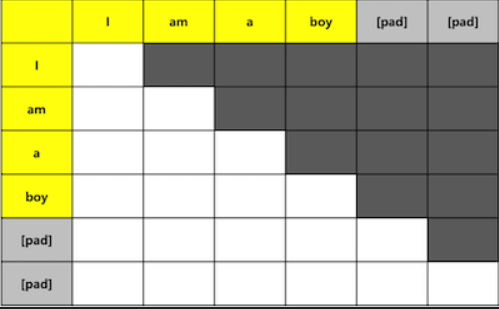

- This is implemented in `make_look_ahead_mask` function below.

In [9]:
PAD = 0
_INF = -1e9

def create_padding_mask_1d(tokens, pad_tokens=PAD):
    """
    returns: mask of shape (batch, seq_len, seq_len) where
    positions corresponding to pad_token are -1e9,
    so after adding to scores, they become zero-weight
    """
    batch, seq_len = tokens.shape
    # shape: (batch, seq_len)
    pad_row = (tokens == pad_tokens).astype(np.float32) * _INF
    # expand to (batch, seq_len, seq_len) by repeating along dim = 1
    # return np.repeat(pad_row[:, None, :], seq_len, axis=1)
    return pad_row

In [10]:
def create_padding_mask(tokens, pad_tokens=PAD):
    pad_1d = create_padding_mask_1d(tokens, pad_tokens)
    return np.repeat(pad_1d[:, None, :], tokens.shape[1], 1)

In [11]:
def make_look_ahead_mask(size):
    mask = np.triu(np.ones((size, size)), k=1) * _INF
    return mask  # broadcastable to (batch, seq, seq)

In [12]:
def create_decoder_self_mask(tgt_tokens, pad_tokens=PAD):
    """
    Combines attention padding and look ahead mask for decoder self attention
    tokens shape: (batch, tgt_seq_len)
    returns shape: (batch, tgt_seq_len, tgt_seq_len)
    """
    batch, T = tgt_tokens.shape
    pad_1d = create_padding_mask_1d(tgt_tokens, pad_tokens)  # (batch, T)
    pad_2d = np.repeat(pad_1d[:, None, :], T, 1)  # (batch, T, T)
    lookahead = make_look_ahead_mask(T)[None, :, :]  # (1, T, T)
    return pad_2d + lookahead

In [13]:
def create_cross_mask(src_tokens, tgt_seq_len, pad_tokens=PAD):
    """
    for decoder-encoder  attention, we only need to mask padded sources
    src_tokens shape: (batch, src_seq_len)
    returns shape: (batch, tgt_seq_len, src_seq_len)
    """
    batch, S = src_tokens.shape
    pad_1d = create_padding_mask_1d(src_tokens, pad_tokens)  # (batch, S)
    return np.repeat(pad_1d[:, None, :], tgt_seq_len, 1)  # (batch, T, S)

# 2. Encoder
Each layer has:
1. self attention + residual connection + layer norm.
2. Forward feed (FFN) + residual connection + layer norm.

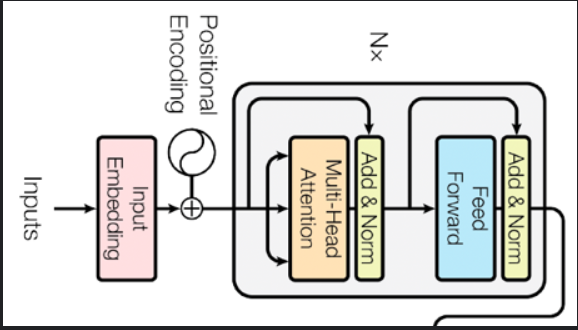

In [7]:
class EncoderLayer:
    def __init__(self, d_model, num_heads, d_ff):
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward(d_model, d_ff)
        self.ln1 = LayerNorm(d_model)
        self.ln2 = LayerNorm(d_model)

    def __call__(self, x, mask=None):
        # self attention -> add & norm
        sa = self.self_attention(x, x, x, mask)
        x2 = self.ln1(x + sa)
        # feed forward -> ad & norm
        ff = self.ffn(x2)
        out = self.ln2(x2 + ff)
        return out

## Full Encoder:
Stack N layers

In [8]:
class Encoder:
    def __init__(self, N, d_model, num_heads, d_ff):

        self.layers = [EncoderLayer(d_model, num_heads, d_ff) for _ in range(N)]

    def __call__(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x  # (batch, seq_len, d_model)

# 3. Decoder:
Has ***three*** sub-layers:
- masked self-attention
- encoder decoder cross attention
- feed forward block

Each followed by residual connection + layer normalization

In [14]:
class DecoderLayer:
    def __init__(self, d_model, num_heads, d_ff):
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.enc_attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward(d_model, d_ff)
        self.ln1 = LayerNorm(d_model)
        self.ln2 = LayerNorm(d_model)
        self.ln3 = LayerNorm(d_model)

    def __call__(self, x, enc_out, self_mask=None, enc_mask=None):
        # 1) Masked self-attention
        sa = self.self_attention(x, x, x, self_mask)
        x2 = self.ln1(x + sa)
        # 2) encoder decoder attention
        ea = self.enc_attention(x2, enc_out, enc_out, enc_mask)
        x3 = self.ln2(x2 + ea)
        # feedforward network
        ff = self.ffn(x3)
        out = self.ln3(x3 + ff)
        return out

## Full Decoder:

Stack N decoder layers

In [15]:
class Decoder:
    def __init__(self, N, d_model, num_heads, d_ff):
        self.layers = [DecoderLayer(d_model, num_heads, d_ff) for _ in range (N)]

    def __call__(self, x, enc_out, self_mask=None, enc_mask=None):
        for layer in self.layers:
            x = layer(x, enc_out, self_mask, enc_mask)
        return x  # shape: (batch, tgt_seq_len, d_model)

# Final Linear + Softmax:
After the decoder --> apply linear layer (Project to vocab. size) and then apply softmax layer

In [16]:
class Transformer:
    def __init__(self, src_vocab, tgt_vocab, n, d_model, num_heads, d_ff):
        self.encoder = Encoder(n, d_model, num_heads, d_ff)
        self.decoder = Decoder(n, d_model, num_heads, d_ff)
        self.source_embedding = embedding
        self.target_embedding = embedding
        self.linear_out = np.random.randn(d_model, tgt_vocab) * 0.01
        self.tgt_vocab = tgt_vocab

    def __call__(self, src_tokens, tgt_tokens, src_mask=None, tgt_self_mask=None, cross_mask=None):
        # 1) Embedding + positional encoding
        encoder_input = embed(src_tokens)
        decoder_input = embed(tgt_tokens)
        # 2) Encoding
        encoder_output = self.encoder(encoder_input, mask=src_mask)
        # 3) Decoding
        decoder_output = self.decoder(decoder_input, encoder_output, self_mask=tgt_self_mask, enc_mask=cross_mask)
        # 4) Projection and softmax
        logits = decoder_output @ self.linear_out  # shape: (batch, tgt_len, vocab)
        exps = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
        probs = exps / np.sum(exps, axis=-1, keepdims=True)
        return probs

## <span style="color:Red">max() function benefit:

To avoid the exponential overflow. For example, if we have logits = [1000 1002 1006], if we  try to calculate exp(1000), we will get overflow, so we subtract a constant from both sides. The values won't change because:

Softmax is defined as:

$$
\mathrm{softmax}(z)_i \;=\; \frac{e^{z_i}}{\sum_j e^{z_j}}.
$$

If you replace \(z_i\) by \(z_i - C\), you get

$$
\frac{e^{z_i - C}}{\sum_j e^{z_j - C}}
\;=\;
\frac{e^{z_i} e^{-C}}{\sum_j e^{z_j} e^{-C}}
\;=\;
\frac{e^{z_i}}{\sum_j e^{z_j}},
$$

because the common factor \(e^{-C}\) cancels out.

# Example:
## 1. Hyperparameters

In [17]:
vocab_size = 30  # token embedding size
d_model = 8  # model dimensionality (must be divisible by num_heads)
num_heads = 2
d_ff = 16  # mlp dimensionality; of the inner feed-forward for a higher dimension
N = 1  # number of encoder and decoder layers
max_len = 20  # max. sequence length for positional encodings (number of tokens)

## 2. Create the global embedding and positional encoding

In [18]:
embedding = np.random.randn(vocab_size, d_model) * 0.01
# print(f"Embeddings of tokens: {embedding}")

Embeddings of tokens: [[ 4.70807220e-03  2.40853450e-03 -1.57112111e-03  2.89956832e-03
   5.64803545e-03 -1.84218537e-02 -2.17894687e-03  6.31241659e-04]
 [ 3.95491150e-03 -2.20145154e-03 -1.38379300e-02 -1.47366808e-02
   4.06862009e-03  2.10375279e-03 -1.90447498e-03 -1.00621556e-02]
 [ 1.49454856e-02 -8.88091185e-03 -6.46904850e-04 -7.23509892e-03
  -1.62902098e-03  1.56853237e-02  7.44465456e-04  1.37335647e-02]
 [ 1.67884038e-02 -1.09564328e-02  6.00779057e-03  1.60140783e-02
  -2.34875993e-03 -1.17633456e-02 -6.76702024e-03  3.27880244e-03]
 [ 8.90897905e-03 -3.50491476e-03  6.11131218e-03 -3.13297131e-05
  -1.76068151e-02  1.38448236e-02 -2.93294184e-02 -1.05167015e-03]
 [-1.48336767e-02 -9.34637373e-03 -1.29107432e-03  9.94524057e-03
  -2.24453868e-03 -2.66062757e-03  1.28666969e-02  1.08435056e-02]
 [-5.01599462e-04  9.33461841e-03 -2.07520994e-03 -6.16805239e-03
   1.41271197e-02  5.17376048e-03 -1.53864695e-03  3.86942454e-03]
 [ 6.08708716e-03 -9.09066035e-03  2.98268506e-

In [19]:
pe_vector = positional_encoding(max_len, d_model)
# print(f"Positional encoding vectors of tokens: {pe_vector}")

Positional encoding vectors of tokens: [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 8.41470985e-01  5.40302306e-01  9.98334166e-02  9.95004165e-01
   9.99983333e-03  9.99950000e-01  9.99999833e-04  9.99999500e-01]
 [ 9.09297427e-01 -4.16146837e-01  1.98669331e-01  9.80066578e-01
   1.99986667e-02  9.99800007e-01  1.99999867e-03  9.99998000e-01]
 [ 1.41120008e-01 -9.89992497e-01  2.95520207e-01  9.55336489e-01
   2.99955002e-02  9.99550034e-01  2.99999550e-03  9.99995500e-01]
 [-7.56802495e-01 -6.53643621e-01  3.89418342e-01  9.21060994e-01
   3.99893342e-02  9.99200107e-01  3.99998933e-03  9.99992000e-01]
 [-9.58924275e-01  2.83662185e-01  4.79425539e-01  8.77582562e-01
   4.99791693e-02  9.98750260e-01  4.99997917e-03  9.99987500e-01]
 [-2.79415498e-01  9.60170287e-01  5.64642473e-01  8.25335615e-01
   5.99640065e-02  9.98200540e-01  5.99996400e-03  9.99982000e-01]
 [ 6.56986599e-01  7.53902254e

In [20]:
def embed(tokens):
    """
    tokens: atrray of shape (batch_size, seq_len), dtype=int
    returns: flaor array of shape (batch_size, seq_len, d_model)
    """
    batch_size, seq_length = tokens.shape
    # print(f"Batch size = {batch_size}, and sequence length = {seq_length}")
    x = embedding[tokens]
    # print(f"Embeddings of the input tokens: {x}")
    x += pe_vector[:seq_length]  # add positional encodings
    # print(f"final vectors including positions awarness: {x}")
    return x

## 3. Instantiate the Transformer

In [21]:
model = Transformer(
    src_vocab=vocab_size,
    tgt_vocab=vocab_size,
    n=N,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff
)
print(f"Model:\n{model}")

Model:


#### 4. Create a tiny batch of token sequences

In [22]:
batch_size = 2
src_seq_len = 6
tgt_seq_len = 5

src_tokens = np.array([
    [5, 2, 17, 8, 9, 0],
    [12, 14, 3, 0, 0, 0]
], dtype=int)

tgt_tokens = np.array ([
    [7, 1, 11, 4, 0],
    [19, 6, 0, 0, 0]
], dtype=int)

## 5. Build masks:

In [23]:
# encoder padding mask
src_mask = create_padding_mask(src_tokens)
print (f"Encoder mask:{src_mask}")

Encoder mask:[[[-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]]

 [[-0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09]
  [-0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09]]]


In [24]:
# 2) build masks via functions
src_mask        = create_padding_mask(src_tokens)
tgt_self_mask   = create_decoder_self_mask(tgt_tokens)
cross_mask      = create_cross_mask(src_tokens, tgt_tokens.shape[1])

## 6. forward pass with masks in place:

In [25]:
probs = model(
    src_tokens,  # shape: (2, 6)
    tgt_tokens,  # shape: (2, 5)
    src_mask=src_mask,
    tgt_self_mask=tgt_self_mask,
    cross_mask=cross_mask
)

In [27]:
print("src_tokens:\n", src_tokens)
print("\n==================================================================\n")
print("src_mask[0]:\n", src_mask[0])  # -1e9 where src_tokens[0] == 0
print("\n==================================================================\n")

print("tgt_tokens:\n", tgt_tokens)
print("\n==================================================================\n")
print("tgt_mask[0]:\n", tgt_self_mask[0])  # combination of look ahead mask and attention padding
print("\n==================================================================\n")

print("Output probabilities (after passing linear transformation and softmax) shape: ", probs.shape)
print("\n==================================================================\n")
print("Example softmax distribution for batch 0, time step 0:\n", probs[0, 0])

src_tokens:
 [[ 5  2 17  8  9  0]
 [12 14  3  0  0  0]]


src_mask[0]:
 [[-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]]


tgt_tokens:
 [[ 7  1 11  4  0]
 [19  6  0  0  0]]


tgt_mask[0]:
 [[-0.e+00 -1.e+09 -1.e+09 -1.e+09 -2.e+09]
 [-0.e+00 -0.e+00 -1.e+09 -1.e+09 -2.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -1.e+09 -2.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -2.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]]


Output probabilities (after passing linear transformation and softmax) shape:  (2, 5, 30)


Example softmax distribution for batch 0, time step 0:
 [0.03228189 0.03170119 0.0347554  0.03451043 0.03301298 0.03173994
 0.03350535 0.03332101 0.03283053 0.03408928 0.03441448 0.03277952
 0.03287835 0.03158863 0.03248526 0.03386371 0.034267